# Исследование данных онлайн-сервиса продажи билетов

- Автор: Юлия Прохорова
- Дата: 14.06.2025

**Цель:**
- провести исследовательский анализ данных, выявить инсайты об изменении пользовательских предпочтений и популярности событий осенью 2024 года;
- проверить гипотезы о разнице в поведении пользователей с мобильными и стационарными устройствами.

<a id='intro-10'></a>
**Содержание проекта:**

[1. Описание данных](#intro-1)

[2. Загрузка данных и знакомство с ними](#intro-2)

[3. Предобработка данных и подготовка их к исследованию](#intro-3)

[4. Исследовательский анализ данных](#intro-4)

[4.1. Анализ распределения заказов по сегментам и их сезонные изменения](#intro-5)

[4.2. Осенняя активность пользователей](#intro-6)

[4.3. Популярные события и партнёры](#intro-7)

[5. Статистический анализ данных](#intro-8)

[6. Общий вывод и рекомендации](#intro-9)

<a id='intro-1'></a>
##  Описание данных

Данные о бронировании билетов на сервисе Яндекс Афиша за период с 1 июня по 30 октября 2024 года.

Датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Датасет содержит поля:
- `order_id` — уникальный идентификатор заказа.
- `user_id` — уникальный идентификатор пользователя.
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
- `event_id` — идентификатор мероприятия из таблицы events.
- `cinema_circuit` — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
- `age_limit` — возрастное ограничение мероприятия.
- `currency_code` — валюта оплаты, например rub для российских рублей.
- `device_type_canonical` — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
- `revenue` — выручка от заказа.
- `service_name` — название билетного оператора.
- `tickets_count` — количество купленных билетов.
- `total` — общая сумма заказа.
- `days_since_prev` - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Датасет `final_tickets_events_df` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Датасет содержит поля:
- `event_id` — уникальный идентификатор мероприятия.
- `event_name` — название мероприятия. 
- `event_type_description` — описание типа мероприятия.
- `event_type_main` — основной тип мероприятия: театральная постановка, концерт и так далее.
- `organizers` — организаторы мероприятия.
- `region_name` — название региона.
- `city_name` — название города.
- `venue_id` — уникальный идентификатор площадки.
- `venue_name` — название площадки.
- `venue_address` — адрес площадки.

Датасет `final_tickets_tenge_df.csv` содержит информацию о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:
- `nominal` — номинал (100 тенге).
- `data` — дата.
- `curs` — курс тенге к рублю.
- `cdx` — обозначение валюты (kzt).

<a id='intro-2'></a>
##  Загрузка данных и знакомство с ними

Загрузим необходимые библиотеки Python.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from scipy.stats import mannwhitneyu
import warnings

warnings.filterwarnings("ignore")  # убираем предупреждения

In [2]:
# Настройка отображения всех столбцов в Jupyter Notebook
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.expand_frame_repr', False)  # Не переносить строки
pd.set_option('display.max_colwidth', None)  # Показывать полное содержимое ячеек

Загрузим данные.

Ознакомимся с данными:

In [4]:
display(orders.head(5))
orders.info()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

In [5]:
display(events.head(5))
events.info()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [6]:
display(tenge.head(5))
tenge.info()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


**Выводы:**

Данные соответствуют описанию. Пропусков нет, за исключением столбца `days_since_prev`. Необходимо преобразовать тип данных содержащих дату.

<a id='intro-3'></a>
##  Предобработка данных и подготовка их к исследованию

Пропуски содержатся в столбце `days_since_prev`. Наличие пропусков говорит о том, что покупки не было. Преобразовывать пропуски не нужно.

Изучим значения в ключевых столбцах для категориальных значений.

In [7]:
# Анализ категориальных значений
for column in ['age_limit', 'currency_code', 'device_type_canonical', 'service_name']:
    print(f"\nColumn: {column}")
    print("Unique values:", orders[column].unique())
    print("Missing values count:", orders[column].isna().sum())
    print("Value counts:")
    print(orders[column].value_counts(dropna=False), "\n")


Column: age_limit
Unique values: [16  0 18 12  6]
Missing values count: 0
Value counts:
16    78579
12    62557
0     61487
6     52173
18    36053
Name: age_limit, dtype: int64 


Column: currency_code
Unique values: ['rub' 'kzt']
Missing values count: 0
Value counts:
rub    285780
kzt      5069
Name: currency_code, dtype: int64 


Column: device_type_canonical
Unique values: ['mobile' 'desktop']
Missing values count: 0
Value counts:
mobile     232679
desktop     58170
Name: device_type_canonical, dtype: int64 


Column: service_name
Unique values: ['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Облачко' 'Лучшие билеты' 'Прачечная' 'Быстробилет'
 'Дом культуры' 'Весь в билетах' 'Билеты в руки' 'Тебе билет!'
 'Show_ticket' 'Городской дом культуры' 'Яблоко' 'Билет по телефону'
 'Выступления.ру' 'Росбилет' 'Шоу начинается!' 'Мир касс' 'Восьмёрка'
 'Телебилет' 'Crazy ticket!' 'Реестр' 'Быстрый кассир' 'КарандашРУ'
 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино б

In [8]:
# Столбец из датафрейма events
print(f"\nColumn: event_type_main")
print("Unique values:", events['event_type_main'].unique())
print("Missing values count:", events['event_type_main'].isna().sum())
print("Value counts:")
print(events['event_type_main'].value_counts(dropna=False), "\n")


Column: event_type_main
Unique values: ['театр' 'концерты' 'ёлки' 'другое' 'стендап' 'выставки' 'спорт']
Missing values count: 0
Value counts:
концерты    8680
театр       7076
другое      4658
спорт        872
стендап      636
выставки     290
ёлки         215
Name: event_type_main, dtype: int64 



Изучим значения в ключевых столбцах для количественных значений.

Рассмотрим распределение данных по выручке.

In [9]:
# Выведим статистику для столбца revenue
display(orders.groupby('currency_code')['revenue'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).loc[['rub', 'kzt']])

,count,mean,std,min,25%,50%,75%,95%,99%,max
currency_code,,,,,,,,,,
rub,285780.0,547.568333,871.524559,-90.76,113.8275,346.10,791.70,1606.50,2569.5942,81174.54
kzt,5069.0,4995.206767,4916.752776,0.00,518.1000,3698.83,7397.66,13784.26,17617.2400,26425.86


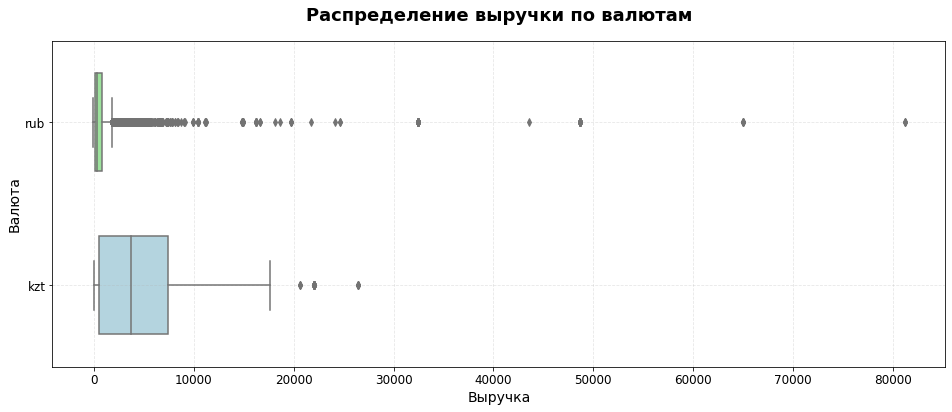

In [10]:
# Построим ящик с усами для столбца revenue
# Фильтруем данные
filtered_data = orders[orders['currency_code'].isin(['rub', 'kzt'])]

# Создаем горизонтальный boxplot с Seaborn
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(data=filtered_data,
                     y='currency_code',  
                     x='revenue',      
                     orient='h',       
                     palette=['lightgreen', 'lightblue'],
                     width=0.6)

# Настройки графика с увеличенными шрифтами
plt.title('Распределение выручки по валютам', 
          pad=20, 
          fontsize=18,  # Увеличиваем размер шрифта заголовка
          fontweight='bold')  # Делаем заголовок полужирным

# Увеличиваем шрифты подписей осей
plt.xlabel('Выручка', fontsize=14)
plt.ylabel('Валюта', fontsize=14)


# Увеличиваем шрифты меток на осях
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

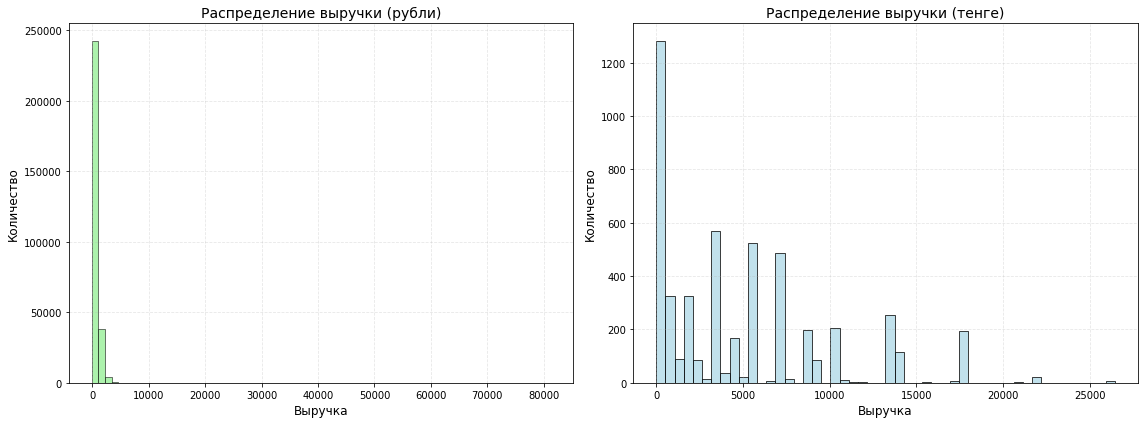

In [11]:
# Построим гистограмму для столбца revenue
# Фильтрация данных
rub_data = orders[orders['currency_code'] == 'rub']
kzt_data = orders[orders['currency_code'] == 'kzt']

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма для рублей
sns.histplot(data=rub_data, x='revenue', ax=ax1, color='lightgreen', bins=70)
ax1.set_title('Распределение выручки (рубли)', fontsize=14)
ax1.set_xlabel('Выручка', fontsize=12)
ax1.set_ylabel('Количество', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

# Гистограмма для тенге
sns.histplot(data=kzt_data, x='revenue', ax=ax2, color='lightblue', bins=50)
ax2.set_title('Распределение выручки (тенге)', fontsize=14)
ax2.set_xlabel('Выручка', fontsize=12)
ax2.set_ylabel('Количество', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()  # Автоматическая подгонка расстояний между графиками
plt.show()

**Выводы:** Распределение данных о выручке в рублях имеет сильную правостороннюю асимметрию с редкими, но очень высокими значениями выручки. Распределение в тенге более сбалансированное, но тоже с перекосом вправо. В рублях больше неоднородности (отрицательные значения, экстремальные максимумы), что требует дополнительной очистки данных. После дополнительной обработки в дальнейшем отберем данные по 99-му процентилю, для исключения выбросов.

Рассмотрим распределение данных о количестве купленных билетов.

In [12]:
# выведим статистику для столбца tickets_count
display(orders.groupby('currency_code')['tickets_count'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).loc[['rub', 'kzt']])

,count,mean,std,min,25%,50%,75%,95%,99%,max
currency_code,,,,,,,,,,
rub,285780.0,2.754077,1.171419,1.0,2.0,3.0,4.0,5.0,6.0,57.0
kzt,5069.0,2.762872,1.115558,1.0,2.0,3.0,4.0,5.0,6.0,6.0


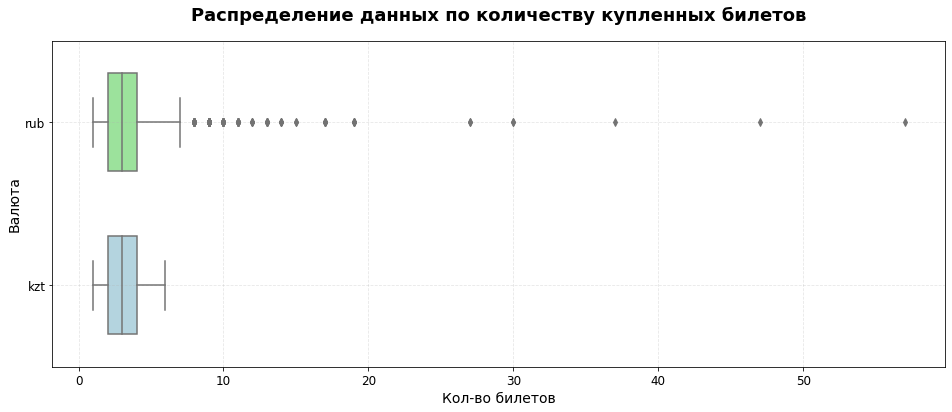

In [13]:
# Построим ящик с усами для столбца tickets_count
# Фильтруем данные
filtered_data = orders[orders['currency_code'].isin(['rub', 'kzt'])]

# Создаем горизонтальный boxplot с Seaborn
plt.figure(figsize=(16, 6))
boxplot = sns.boxplot(data=filtered_data,
                     y='currency_code',  
                     x='tickets_count',      
                     orient='h',       
                     palette=['lightgreen', 'lightblue'],
                     width=0.6)

# Настройки графика с увеличенными шрифтами
plt.title('Распределение данных по количеству купленных билетов', 
          pad=20, 
          fontsize=18,  # Увеличиваем размер шрифта заголовка
          fontweight='bold')  # Делаем заголовок полужирным

# Увеличиваем шрифты подписей осей
plt.xlabel('Кол-во билетов', fontsize=14)
plt.ylabel('Валюта', fontsize=14)


# Увеличиваем шрифты меток на осях
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Настройка сетки
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

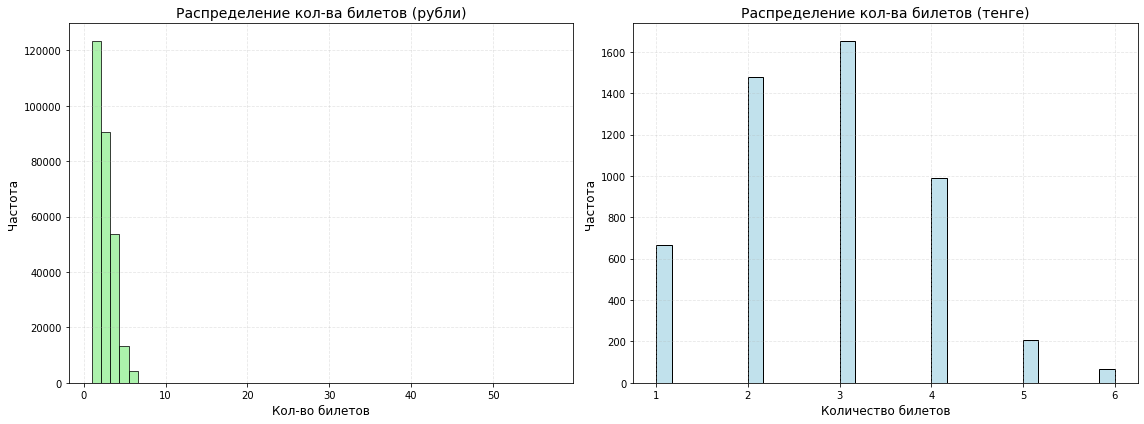

In [14]:
# Построим гистограмму для столбца tickets_count
# Фильтрация данных
rub_data = orders[orders['currency_code'] == 'rub']
kzt_data = orders[orders['currency_code'] == 'kzt']

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Гистограмма для рублей
sns.histplot(data=rub_data, x='tickets_count', ax=ax1, color='lightgreen', bins=50)
ax1.set_title('Распределение кол-ва билетов (рубли)', fontsize=14)
ax1.set_xlabel('Кол-во билетов', fontsize=12)
ax1.set_ylabel('Частота', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.3)

# Гистограмма для тенге
sns.histplot(data=kzt_data, x='tickets_count', ax=ax2, color='lightblue', bins=30)
ax2.set_title('Распределение кол-ва билетов (тенге)', fontsize=14)
ax2.set_xlabel('Количество билетов', fontsize=12)
ax2.set_ylabel('Частота', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()  # Автоматическая подгонка расстояний между графиками
plt.show()

**Вывод:** распределение данных о количестве купленных билетов в рублях и тенге очень похоже по средним значениям и квартилям. Основное отличие — в рублях есть редкие аномально большие покупки (до 57 билетов), тогда как в тенге максимальное количество покупок не превышает 6. Разброс данных немного выше в рублях, но в целом тенденции схожи. Большинство покупателей (75%) берут не более 4 билетов в обеих валютах. Аномальные значения можно исключить.

Проведём преобразование типа данных для столбцов с датами.

In [15]:
orders['created_dt_msk'] = pd.to_datetime(orders['created_dt_msk'])
orders['created_ts_msk'] = pd.to_datetime(orders['created_ts_msk'])
tenge['data'] = pd.to_datetime(tenge['data'])

Объединим данные в один датафрейм.

Размеры датасетов до объединения:

In [16]:
print('Датасет orders:')
print(orders.info())
print('--------------------------------------------------------')
print('Датасет events:')
print(events.info())
print('--------------------------------------------------------')
print('Датасет tenge:')
print(tenge.info())

Датасет orders:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  29084

In [17]:
# Объединим датасеты
merged = pd.merge(orders, events, on='event_id', how='left')
final_merged = pd.merge(merged, tenge, left_on='created_dt_msk', right_on='data', how='left')

Размер результирующего датафрейма (объединен по типу left):

In [18]:
final_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290849 entries, 0 to 290848
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290849 non-null  int64         
 1   user_id                 290849 non-null  object        
 2   created_dt_msk          290849 non-null  datetime64[ns]
 3   created_ts_msk          290849 non-null  datetime64[ns]
 4   event_id                290849 non-null  int64         
 5   cinema_circuit          290849 non-null  object        
 6   age_limit               290849 non-null  int64         
 7   currency_code           290849 non-null  object        
 8   device_type_canonical   290849 non-null  object        
 9   revenue                 290849 non-null  float64       
 10  service_name            290849 non-null  object        
 11  tickets_count           290849 non-null  int64         
 12  total                   290849

Датасеты объедены по left, количество строк соответствуют основному датасету `orders`.

Посмотрим на итоговый датасет.

In [19]:
final_merged.head(3)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,data,nominal,curs,cdx
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",2024-08-20,100,18.6972,kzt
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",2024-07-23,100,18.3419,kzt
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",2024-10-06,100,19.6475,kzt


Удалим не нужные столбцы.

In [20]:
final_merged = final_merged.drop(columns=['data'])
final_merged = final_merged.drop(columns=['cdx'])

Проверим явные и неявные дубликаты.

In [21]:
# Проверяем явные дубликаты
final_merged.duplicated().sum()

0

In [22]:
# Проверяем неявные дубликаты
final_merged.duplicated(subset=final_merged.columns.difference(['order_id'])).sum()

30

In [23]:
# Выведем неявные дубликаты
cols_to_check = final_merged.columns.difference(['order_id'])
grouped_duplicates = final_merged[final_merged.duplicated(subset=cols_to_check, keep=False)] \
    .groupby(cols_to_check.tolist()) \
    .apply(lambda x: x) \
    .sort_values(by=cols_to_check.tolist())

display(grouped_duplicates) 

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,nominal,curs
228554,2768196,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,87.02,Билеты без проблем,4,4350.98,0.0,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2.0,1283.0,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9",100,17.8998
228559,2768051,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,87.02,Билеты без проблем,4,4350.98,0.0,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2.0,1283.0,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9",100,17.8998
228555,2768167,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,108.77,Билеты без проблем,5,5438.72,0.0,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2.0,1283.0,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9",100,17.8998
228561,2767964,c2c6d35ff678ca6,2024-08-06,2024-08-06 13:26:42,379268,нет,0,rub,mobile,108.77,Билеты без проблем,5,5438.72,0.0,b16a8d23-6085-4b04-8b8a-35b74a3d89f2,событие,другое,№2685,Североярская область,Озёрск,2.0,1283.0,"Клуб начинающих писателей ""Детство"" Лимитед","ул. Заозерная, д. 9",100,17.8998
154981,3463732,7eb4fc207ecc10f,2024-09-21,2024-09-21 11:43:58,448579,нет,0,rub,mobile,2.54,Лови билет!,1,84.82,0.0,a751c430-d352-44d7-99a0-29e97193eba5,спорт,спорт,№1622,Североярская область,Озёрск,2.0,4607.0,"Команда артистов ""Светлячок"" Лимитед","пер. Невского, д. 72",100,19.3316
154993,3463819,7eb4fc207ecc10f,2024-09-21,2024-09-21 11:43:58,448579,нет,0,rub,mobile,2.54,Лови билет!,1,84.82,0.0,a751c430-d352-44d7-99a0-29e97193eba5,спорт,спорт,№1622,Североярская область,Озёрск,2.0,4607.0,"Команда артистов ""Светлячок"" Лимитед","пер. Невского, д. 72",100,19.3316
176438,8248268,8f95286aa5fd8d7,2024-06-20,2024-06-20 10:57:19,244875,нет,0,rub,mobile,15.73,Лови билет!,3,524.39,0.0,61f8b9bd-a66f-4cd9-ae10-a0e62e923476,выставка,другое,№3906,Каменноозёрный край,Ордакент,12.0,2492.0,"Кинофестиваль ""Хранитель"" Инкорпорэйтед","пр. Балтийский, д. 8 к. 51",100,18.0419
176439,8248210,8f95286aa5fd8d7,2024-06-20,2024-06-20 10:57:19,244875,нет,0,rub,mobile,15.73,Лови билет!,3,524.39,0.0,61f8b9bd-a66f-4cd9-ae10-a0e62e923476,выставка,другое,№3906,Каменноозёрный край,Ордакент,12.0,2492.0,"Кинофестиваль ""Хранитель"" Инкорпорэйтед","пр. Балтийский, д. 8 к. 51",100,18.0419
148473,2324032,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",100,19.9266
148477,2323916,7b525118ae656af,2024-10-28,2024-10-28 08:33:04,588203,нет,0,rub,mobile,26.96,Лучшие билеты,4,674.12,0.0,88478781-0311-42e3-b0ea-d4d6a171b70a,спорт,спорт,№1503,Чистогорская область,Песчанская,21.0,2155.0,"Клуб моделей ""Гармония"" Инк","ул. Прохладная, д. 8 к. 432",100,19.9266


Неявные дубликаты можно удалить, видно что заказы по дате и времени в системе задублировались.

In [24]:
# Удаляем дубликаты, игнорируя столбец order_id
final_merged_cleaned = final_merged.drop_duplicates(
    subset=final_merged.columns.difference(['order_id']),
    keep='first'  
)

# Проверяем количество оставшихся дубликатов 
remaining_duplicates = final_merged_cleaned.duplicated(
    subset=final_merged_cleaned.columns.difference(['order_id'])
).sum()
print(f"Оставшееся количество дубликатов: {remaining_duplicates}")

Оставшееся количество дубликатов: 0


Посмотрим информацию об объединённом датафрейме.

In [25]:
final_merged_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290819 entries, 0 to 290848
Data columns (total 26 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290819 non-null  int64         
 1   user_id                 290819 non-null  object        
 2   created_dt_msk          290819 non-null  datetime64[ns]
 3   created_ts_msk          290819 non-null  datetime64[ns]
 4   event_id                290819 non-null  int64         
 5   cinema_circuit          290819 non-null  object        
 6   age_limit               290819 non-null  int64         
 7   currency_code           290819 non-null  object        
 8   device_type_canonical   290819 non-null  object        
 9   revenue                 290819 non-null  float64       
 10  service_name            290819 non-null  object        
 11  tickets_count           290819 non-null  int64         
 12  total                   290819

In [26]:
# Подсчитываем процент строк с пропусками
round(final_merged_cleaned.isna().sum() / final_merged_cleaned.shape[0]*100, 1)

order_id                  0.0
user_id                   0.0
created_dt_msk            0.0
created_ts_msk            0.0
event_id                  0.0
cinema_circuit            0.0
age_limit                 0.0
currency_code             0.0
device_type_canonical     0.0
revenue                   0.0
service_name              0.0
tickets_count             0.0
total                     0.0
days_since_prev           7.5
event_name                0.1
event_type_description    0.1
event_type_main           0.1
organizers                0.1
region_name               0.1
city_name                 0.1
city_id                   0.1
venue_id                  0.1
venue_name                0.1
venue_address             0.1
nominal                   0.0
curs                      0.0
dtype: float64

Оставим пропуски без изменений, при необходимости учтем в дальнейшем анализе.

Для дальнейшего анализа создадим несколько новых столбцов:
- `revenue_rub` — приведем выручку с заказа к единой валюте — российскому рублю; 
- `one_ticket_revenue_rub` — рассчитаем выручку с продажи одного билета на мероприятие;
- `month` — выделим месяц оформления заказа в отдельный столбец;
- `season` — создадим столбец с информацией о сезонности, включая такие категории, как: 'лето', 'осень', 'зима', 'весна'.

In [27]:
# Код для столбца revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'kzt':
        return row['revenue'] * row['curs'] / 100  # KZT → RUB
    elif row['currency_code'] == 'rub':
        return row['revenue']  # уже в рублях
    else:
        return None  

final_merged_cleaned['revenue_rub'] = final_merged_cleaned.apply(convert_to_rub, axis=1)

In [28]:
# Код для столбца one_ticket_revenue_rub
final_merged_cleaned['one_ticket_revenue_rub'] = final_merged_cleaned['revenue_rub'] / final_merged_cleaned['tickets_count']

In [29]:
# Код для столбца month
final_merged_cleaned['month'] = final_merged_cleaned['created_dt_msk'].dt.month

In [30]:
# Код для столбца season
final_merged_cleaned['season'] = final_merged_cleaned['month'].apply(
    lambda x: 'лето' if x in [6, 7, 8] else 'осень'
)

Удалим выбросы, содержащие 1% данных для столбца `revenue_rub`.

In [31]:
# Находим 99-й процентиль по столбцу revenue_rub
threshold = final_merged_cleaned['revenue_rub'].quantile(0.99)

# Фильтруем датафрейм, оставляя только строки, где revenue_rub < threshold
total_df = final_merged_cleaned[final_merged_cleaned['revenue_rub'] < threshold]

In [32]:
threshold

2628.4217390400004

In [33]:
# Проверим созданные столбцы
total_df.head(3)

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,nominal,curs,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213.0,3972.0,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",100,18.6972,1521.94,380.4850,8,лето
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN,40efeb04-81b7-4135-b41f-708ff00cc64c,событие,выставки,№4850,Каменевский регион,Глиногорск,213.0,2941.0,"Музыкальная школа для детей ""Аккаунт"" Лтд","алл. Шмидта, д. 9 стр. 4",100,18.3419,289.45,144.7250,7,лето
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,цирковое шоу,другое,№1540,Каменевский регион,Глиногорск,213.0,4507.0,"Училище искусств ""Нирвана"" Инк","алл. Юбилейная, д. 5/6",100,19.6475,1258.57,314.6425,10,осень


**Вывод:** 

В результате предобработки данных были выполнены следующие преобразования:
- изучены значения в ключевых столбцах для категориальных и количественных переменных;
- удалены выбросы (1% данных) в столбце с выручкой;
- данные с датами приведены к корректному формату;
- исключены задвоенные заказы;
- создан объединённый датасет.

Добавлены новые столбцы:
- `revenue_rub` – приведение выручки заказов к единой валюте (российский рубль);
- `one_ticket_revenue_rub` – расчёт выручки с одного билета;
- `month` – выделение месяца оформления заказа;
- `season` – определение сезонности с категориями: лето, осень.

<a id='intro-4'></a>
##  Исследовательский анализ данных

<a id='intro-5'></a>
###  Анализ распределения заказов по сегментам и их сезонные изменения

Изучим изменение пользовательской активности или пользовательского интереса в связи с сезонностью. Проанализируем динамику по таким разрезам:
- тип мероприятия `event_type_main`;
- тип устройства `device_type_canonical`;
- категория мероприятий по возрастному рейтингу `age_limit`.

Для каждого месяца найдем количество заказов.

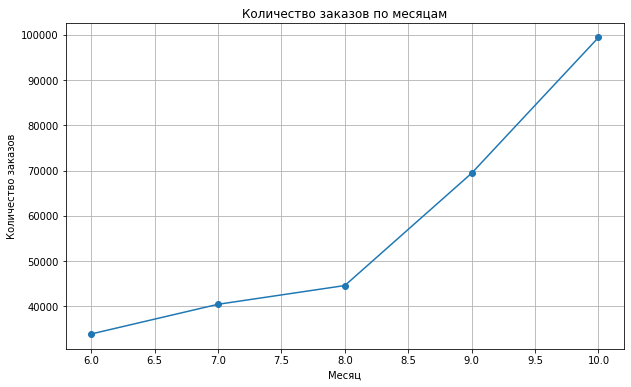

In [34]:
# Группировка по month и подсчёт количества order_id
monthly_orders = total_df.groupby('month')['order_id'].count().reset_index()

# Построение линейного графика
plt.figure(figsize=(10, 6))
plt.plot(monthly_orders['month'], monthly_orders['order_id'], marker='o')

# Добавление подписей
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.grid(True)

# Отображение графика
plt.show()

На графике видно увеличение заказов от июня к ноябрю 2024 года.

Для осеннего и летнего периодов сравним распределение заказов билетов по разным категориям: тип мероприятия, тип устройства, категория мероприятия по возрастному рейтингу.

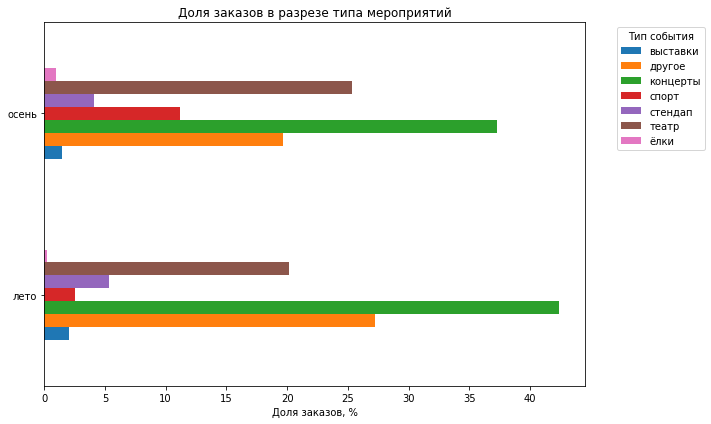

In [35]:
# График распределения заказов для event_type_main в долях
# Группировка данных по столбцам 'season' и 'event_type_main'
grouped_data = total_df.groupby(['season', 'event_type_main']).size().unstack()

# Переводим абсолютные значения в доли (проценты) по строкам
grouped_data_percent = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Построение столбчатой диаграммы
ax = grouped_data_percent.plot(kind='barh', stacked=False, figsize=(10, 6))
plt.title('Доля заказов в разрезе типа мероприятий')
plt.xlabel('Доля заказов, %')
plt.ylabel('')

# Выносим легенду за пределы графика
plt.legend(title='Тип события', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Автоматическая подгонка layout'а чтобы легенда не обрезалась
plt.show()

In [36]:
grouped_data_percent

event_type_main,выставки,другое,концерты,спорт,стендап,театр,ёлки
season,,,,,,,
лето,2.034595,27.259023,42.423324,2.531454,5.345864,20.175838,0.229902
осень,1.442889,19.679792,37.259815,11.183571,4.101215,25.328737,1.003980


Осенью увеличилось количество заказов билетов на такие мероприятия, как `ёлки`, `театры` и `спорт`, но снизилось на `стендапы`, `концерты`, `выставки` и другое.

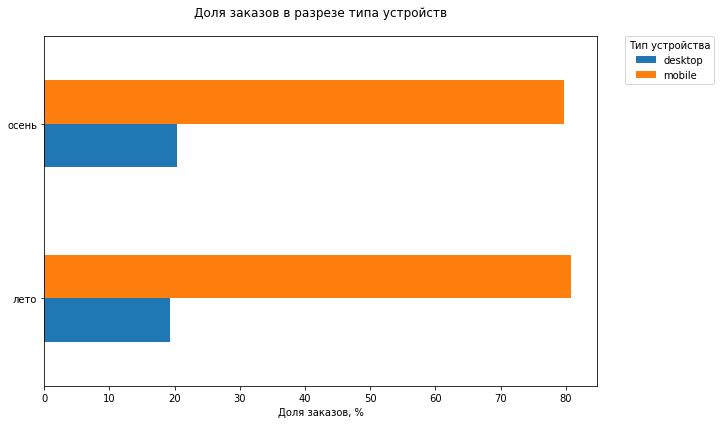

In [37]:
# График распределения заказов для device_type_canonical в долях
# Группировка данных по столбцам 'season' и 'device_type_canonical'
grouped_data = total_df.groupby(['season', 'device_type_canonical']).size().unstack()

# Переводим абсолютные значения в доли (проценты) по строкам
grouped_data_percent = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Построение столбчатой диаграммы с сохранением объекта Axes
ax = grouped_data_percent.plot(kind='barh', 
                              stacked=False, 
                              figsize=(12, 6))  

# Настройка заголовка и подписей
plt.title('Доля заказов в разрезе типа устройств', pad=20)
plt.xlabel('Доля заказов, %')
plt.ylabel('')

# Выносим легенду за пределы графика и настраиваем ее
plt.legend(title='Тип устройства',
           bbox_to_anchor=(1.05, 1),  # Размещаем справа от графика
           loc='upper left',          # Выравниваем по верхнему краю
           borderaxespad=0.)          # Убираем отступы вокруг легенды

# Автоматическая подгонка layout'а
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Оставляем 15% справа для легенды
plt.show()

Доля заказов с разных устройств не имеет выраженной сезонности.

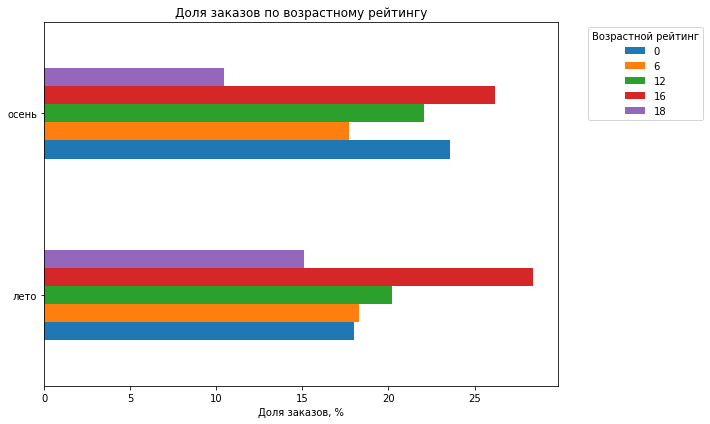

In [38]:
# График распределения заказов для age_limit в долях
# Группировка данных по столбцам 'season' и 'age_limit'
grouped_data = total_df.groupby(['season', 'age_limit']).size().unstack()

# Переводим абсолютные значения в доли (проценты) по строкам
grouped_data_percent = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Построение столбчатой диаграммы
ax = grouped_data_percent.plot(kind='barh', stacked=False, figsize=(10, 6))
plt.title('Доля заказов по возрастному рейтингу')
plt.xlabel('Доля заказов, %')
plt.ylabel('')

# Выносим легенду за пределы графика и исправляем название
plt.legend(title='Возрастной рейтинг', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Автоматическая подгонка layout'а, чтобы легенда не обрезалась
plt.show()

In [39]:
grouped_data_percent

age_limit,0,6,12,16,18
season,,,,,
лето,17.992300,18.305005,20.213177,28.404028,15.085489
осень,23.590761,17.696180,22.090613,26.193071,10.429375


Возрастные ограничения мероприятий демонстрируют заметную сезонную динамику.
Наиболее ярко это проявляется в категориях 0+ и 18+.
Осенью наблюдается:
- снижение спроса на мероприятия с ограничениями 18+ и 16+;
- рост популярности мероприятий для аудитории 0+ и 12+.

При этом спрос на мероприятия категории 6+ остается стабильным. 

Можно также заметить, что с июня по октябрь отмечается устойчивый рост количества заказов по различным сегментам.

Изучим изменение выручки с продажи одного билета в зависимости от типа мероприятия летом и осенью. 

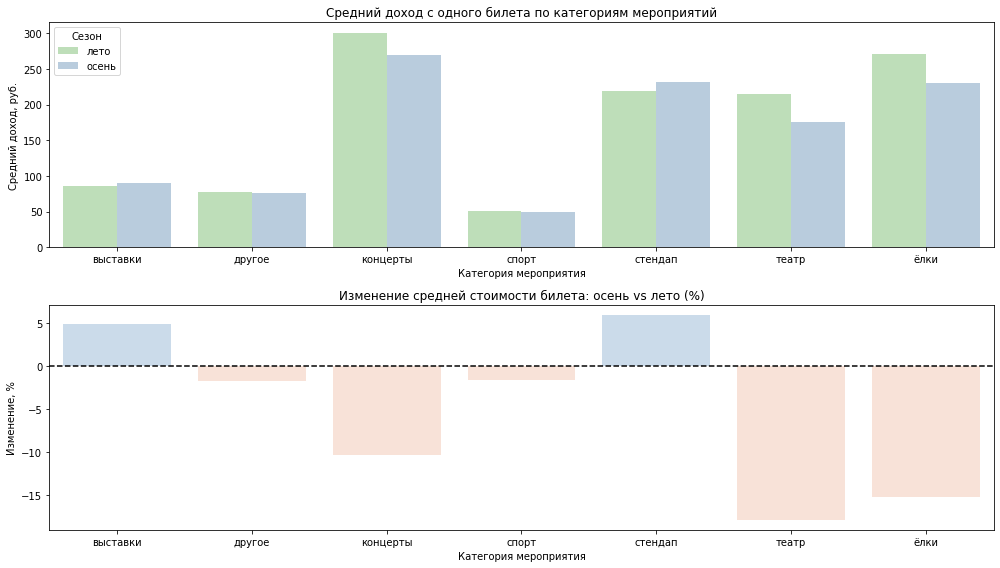

season,лето,осень,autumn_vs_summer_pct_change
event_type_main,,,
стендап,218.585827,231.466954,5.89
выставки,86.416198,90.603610,4.85
спорт,50.761831,49.969733,-1.56
другое,77.433968,76.115334,-1.70
концерты,300.274761,269.319652,-10.31
ёлки,271.436176,230.310069,-15.15
театр,214.398965,176.231359,-17.80


In [40]:
# 1. Группируем данные и считаем средний доход с билета
average_revenue = (
    total_df.groupby(['season', 'event_type_main'])['one_ticket_revenue_rub']
    .mean()
    .reset_index()
    .rename(columns={'one_ticket_revenue_rub': 'avg_revenue_per_ticket_rub'})
)

# 2. Создаём сводную таблицу для удобства сравнения
pivot_revenue = average_revenue.pivot(
    index='event_type_main',
    columns='season',
    values='avg_revenue_per_ticket_rub'
)

# 3. Рассчитываем относительное изменение осени к лету (%)
pivot_revenue['autumn_vs_summer_pct_change'] = (
    (pivot_revenue['осень'] - pivot_revenue['лето']) 
    / pivot_revenue['лето'] * 100).round(2)

# 4. Визуализация
plt.figure(figsize=(14, 8))

# График среднего дохода по категориям и сезонам
plt.subplot(2, 1, 1)
sns.barplot(
    data=average_revenue,
    x='event_type_main',
    y='avg_revenue_per_ticket_rub',
    hue='season',
    palette={'лето': '#bae4b3', 'осень': '#b3cde3'}
)
plt.title('Средний доход с одного билета по категориям мероприятий')
plt.xlabel('Категория мероприятия')
plt.ylabel('Средний доход, руб.')
plt.xticks(rotation=0)
plt.legend(title='Сезон')

# График процентного изменения осень/лето
plt.subplot(2, 1, 2)

# Создаем список цветов - синий для положительных, красный для отрицательных
colors = ['#fee0d2' if x < 0 else '#c6dbef' for x in pivot_revenue['autumn_vs_summer_pct_change']]

sns.barplot(
    x=pivot_revenue.index,
    y=pivot_revenue['autumn_vs_summer_pct_change'],
    palette=colors
)
plt.axhline(0, color='black', linestyle='--')
plt.title('Изменение средней стоимости билета: осень vs лето (%)')
plt.xlabel('Категория мероприятия')
plt.ylabel('Изменение, %')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

# Выводим таблицу с результатами
display(pivot_revenue.sort_values('autumn_vs_summer_pct_change', ascending=False))

**Вывод:** летом и осенью наблюдается динамика средней стоимости билета в разрезе разных категорий мероприятий.
- Развлекательные мероприятия (стендап, выставки) дорожают осенью.
- Культурные (театр, ёлки, концерты) и спортивные события, наоборот, дешевеют.
- Театр показывает самое значительное снижение цены (–17.8%), что может быть связано с сезонным спросом.

<a id='intro-6'></a>
###  Осенняя активность пользователей

Изучим активность пользователей осенью 2024 года.

Проанализируем динамику изменений по дням для:
- общего числа заказов;
- количества активных пользователей DAU;
- среднего числа заказов на одного пользователя;
- средней стоимости одного билета.
Для этого создадим одну сводную таблицу, и в ней по дням рассчитаем число заказов и число уникальных пользователей, а затем найдем величину — количество заказов на одного пользователя. Полученные результаты визуализируем с помощью линейного графика. 

Изучим недельную цикличность. Выделим день недели и сравним пользовательскую активность в будни и выходные.

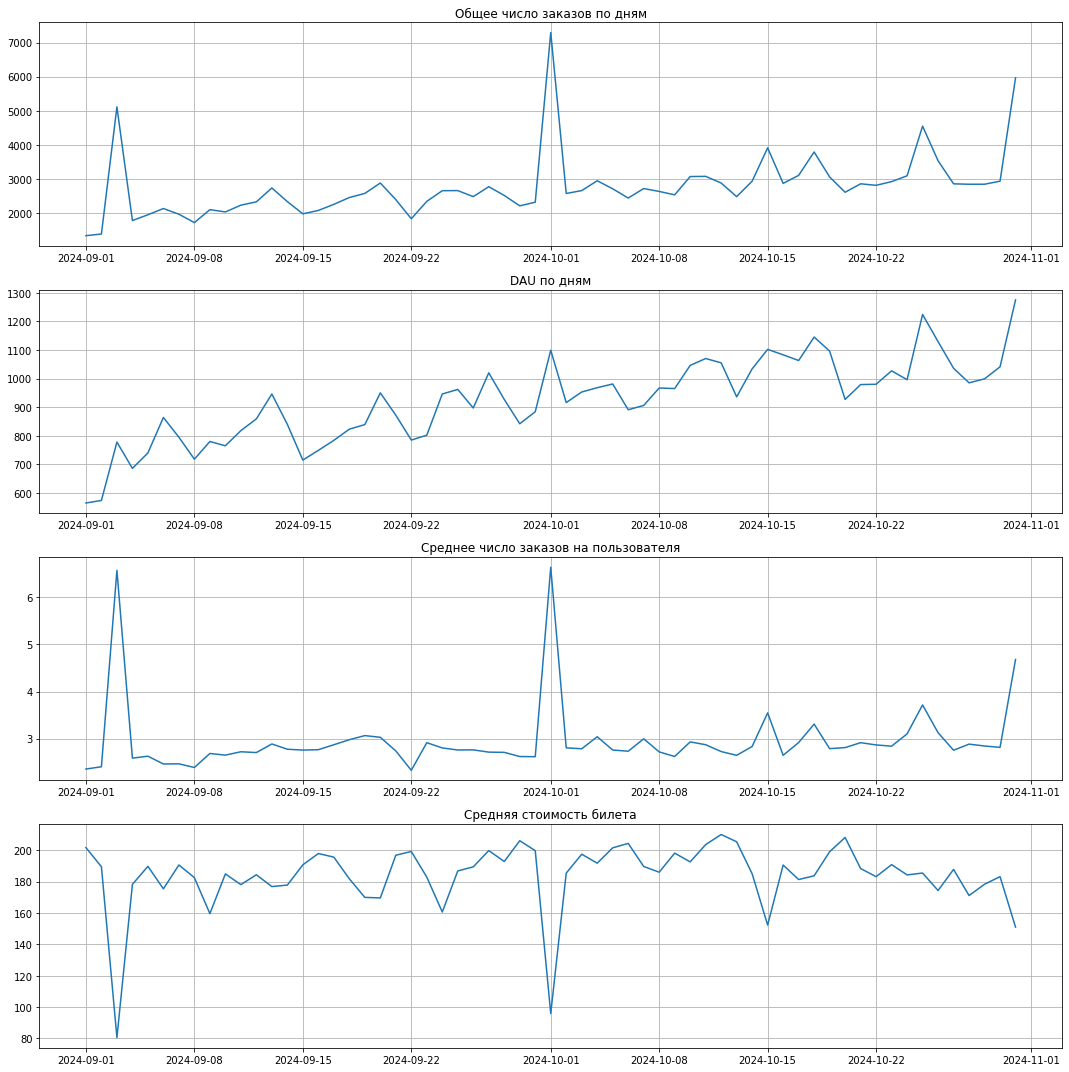

In [41]:
# Извлекаем день недели
total_df['day_of_week'] = total_df['created_dt_msk'].dt.day_name()

# Фильтруем данные только на осень 2024
autumn_2024_df = total_df[total_df['season'] == 'осень']

# Создаем сводную таблицу по дням
daily_stats = autumn_2024_df.groupby('created_dt_msk').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    avg_revenue=('one_ticket_revenue_rub', 'mean')
).reset_index()

# Рассчитываем среднее число заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['total_orders'] / daily_stats['dau']

# Визуализация динамики по дням
plt.figure(figsize=(15, 15))  # Увеличиваем высоту figure для вертикального расположения

# График общего числа заказов
plt.subplot(4, 1, 1)  # 4 строки, 1 столбец, позиция 1
plt.plot(daily_stats['created_dt_msk'], daily_stats['total_orders'])
plt.title('Общее число заказов по дням')
plt.grid(True)

# График DAU
plt.subplot(4, 1, 2)  # 4 строки, 1 столбец, позиция 2
plt.plot(daily_stats['created_dt_msk'], daily_stats['dau'])
plt.title('DAU по дням')
plt.grid(True)

# График среднего числа заказов на пользователя
plt.subplot(4, 1, 3)  # 4 строки, 1 столбец, позиция 3
plt.plot(daily_stats['created_dt_msk'], daily_stats['orders_per_user'])
plt.title('Среднее число заказов на пользователя')
plt.grid(True)

# График средней стоимости билета
plt.subplot(4, 1, 4)  # 4 строки, 1 столбец, позиция 4
plt.plot(daily_stats['created_dt_msk'], daily_stats['avg_revenue'])
plt.title('Средняя стоимость билета')
plt.grid(True)

plt.tight_layout()
plt.show()

**Вывод:** 
Осенью 2024 года наблюдается положительная динамика: общее число заказов и количество активных пользователей постепенно увеличиваются. Среднее число заказов на одного пользователя остаётся стабильным, с пиками в отдельные дни. Средняя стоимость билета колеблется, но не демонстрирует чёткой тенденции.


In [42]:
# Анализ недельной цикличности
weekday_stats = autumn_2024_df.groupby('day_of_week').agg(
    total_orders=('order_id', 'count'),
    dau=('user_id', 'nunique'),
    avg_revenue=('one_ticket_revenue_rub', 'mean')
).reset_index()

# Добавляем флаг выходного дня и сортируем по дням недели
weekday_stats['is_weekend'] = weekday_stats['day_of_week'].isin(['Saturday', 'Sunday'])
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_stats['day_of_week'] = pd.Categorical(weekday_stats['day_of_week'], categories=day_order, ordered=True)
weekday_stats = weekday_stats.sort_values('day_of_week')

# Выводим таблицу по дням недели
print("\nСтатистика по дням недели:")
display(weekday_stats[['day_of_week', 'total_orders', 'dau', 'avg_revenue', 'is_weekend']]
        .rename(columns={
            'day_of_week': 'День недели',
            'total_orders': 'Всего заказов',
            'dau': 'DAU',
            'avg_revenue': 'Ср. стоимость билета (руб)',
            'is_weekend': 'Выходной'
        }))



Статистика по дням недели:


,День недели,Всего заказов,DAU,Ср. стоимость билета (руб),Выходной
1,Monday,21541,4453,184.599724,False
5,Tuesday,31533,4799,141.391475,False
6,Wednesday,22924,4819,186.366622,False
4,Thursday,27200,4974,178.370879,False
0,Friday,24861,4872,186.124307,False
2,Saturday,21365,4574,192.674246,True
3,Sunday,19426,4399,198.776119,True


In [43]:
# Группируем по будням/выходным и выводим сравнение
weekend_comparison = weekday_stats.groupby('is_weekend').agg({
    'total_orders': 'mean',
    'dau': 'mean',
    'avg_revenue': 'mean'
}).reset_index()

print("\nСравнение активности в будни и выходные:")
weekend_comparison_display = weekend_comparison.copy()
weekend_comparison_display['is_weekend'] = weekend_comparison_display['is_weekend'].map({True: 'Выходные', False: 'Будни'})
display(weekend_comparison_display.rename(columns={
    'is_weekend': 'Тип дня',
    'total_orders': 'Ср. число заказов',
    'dau': 'Ср. DAU',
    'avg_revenue': 'Ср. стоимость билета (руб)'
}))


Сравнение активности в будни и выходные:


,Тип дня,Ср. число заказов,Ср. DAU,Ср. стоимость билета (руб)
0,Будни,25611.8,4783.4,175.370601
1,Выходные,20395.5,4486.5,195.725182



**Вывод:** Среднее число заказов и активность пользователей в будни выше, чем в выходные. Средняя стоимость билета напротив в будни ниже, чем в выходные.

<a id='intro-7'></a>
###  Популярные события и партнёры

Посмотрим, как события распределены по регионам и партнёрам. Это позволит выделить ключевые регионы и партнёров, которые вносят наибольший вклад в выручку.

Для каждого региона посчитаем уникальное количество мероприятий и общее число заказов. 

Для каждого билетного партнёра посчитаем общее число уникальных мероприятий, обработанных заказов и суммарную выручку с заказов билетов. 


Топ-10 регионов по количеству мероприятий:


,region_name,event_id,order_id,event_share,order_share
23,Каменевский регион,5940,89749,0.265605,0.312090
60,Североярская область,3800,43752,0.169916,0.152142
77,Широковская область,1232,16172,0.055089,0.056236
57,Светополянский округ,1075,7502,0.048068,0.026087
52,Речиновская область,702,6268,0.031390,0.021796
74,Травяная область,683,5036,0.030540,0.017512
11,Горицветская область,551,5154,0.024638,0.017922
61,Серебринская область,541,5591,0.024191,0.019442
78,Яблоневская область,535,6123,0.023922,0.021292
69,Тепляковская область,528,4385,0.023609,0.015248


<Figure size 864x432 with 0 Axes>

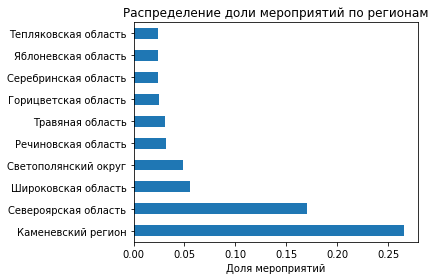


Топ-10 билетных партнеров по количеству мероприятий:


,service_name,event_id,order_id,revenue_rub,event_share,order_share
21,Лови билет!,4872,40825,1.673015e+07,0.217850,0.141963
3,Билеты без проблем,4256,63254,2.485658e+07,0.190306,0.219957
5,Билеты в руки,3536,40305,1.320475e+07,0.158111,0.140155
25,Облачко,2335,26410,1.860930e+07,0.104409,0.091837
22,Лучшие билеты,1763,17762,2.724061e+06,0.078832,0.061765
24,Мой билет,1302,33961,2.058398e+07,0.058219,0.118095
30,Тебе билет!,1062,5200,2.988325e+06,0.047487,0.018082
26,Прачечная,1026,10222,4.746811e+06,0.045877,0.035546
8,Весь в билетах,856,16438,1.656688e+07,0.038276,0.057161
35,Яблоко,714,5005,3.870923e+06,0.031926,0.017404


<Figure size 864x432 with 0 Axes>

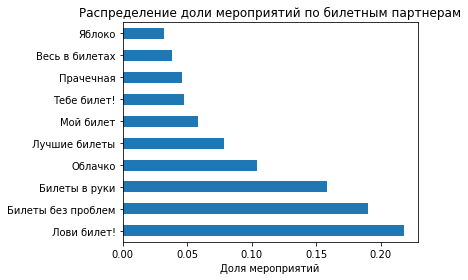

In [44]:
# Анализ по регионам
region_stats = total_df.groupby('region_name').agg(
    event_id=('event_id', 'nunique'),
    order_id=('order_id', 'count')
).reset_index()

# Считаем доли
total_events = region_stats['event_id'].sum()
total_orders = region_stats['order_id'].sum()

region_stats['event_share'] = region_stats['event_id'] / total_events
region_stats['order_share'] = region_stats['order_id'] / total_orders

# Сортируем и выводим топ-10 по event_id
region_stats_sorted = region_stats.sort_values('event_id', ascending=False).head(10)
print("Топ-10 регионов по количеству мероприятий:")
display(region_stats_sorted)

# Диаграмма распределения доли мероприятий по регионам
plt.figure(figsize=(12, 6))
region_stats_sorted.plot.barh(x='region_name', y='event_share', legend=False)
plt.title('Распределение доли мероприятий по регионам')
plt.ylabel('')
plt.xlabel('Доля мероприятий')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Анализ по билетным партнерам
partner_stats = total_df.groupby('service_name').agg(
    event_id=('event_id', 'nunique'),
    order_id=('order_id', 'count'),
    revenue_rub=('revenue_rub', 'sum')
).reset_index()

# Считаем доли
partner_stats['event_share'] = partner_stats['event_id'] / total_events
partner_stats['order_share'] = partner_stats['order_id'] / total_orders

# Сортируем и выводим топ-10 по event_id
partner_stats_sorted = partner_stats.sort_values('event_id', ascending=False).head(10)
print("\nТоп-10 билетных партнеров по количеству мероприятий:")
display(partner_stats_sorted)

# Диаграмма распределения доли мероприятий по партнерам
plt.figure(figsize=(12, 6))
partner_stats_sorted.plot.barh(x='service_name', y='event_share', legend=False)
plt.title('Распределение доли мероприятий по билетным партнерам')
plt.ylabel('')
plt.xlabel('Доля мероприятий')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Вывод:**

Явные лидеры по количеству заказов два региона (из 81):
- Каменевский регион (31,2%);
- Североярская область (15,2%).

Самые активные партнеры (из 36) по количеству мероприятий:
- Лови билет! (21,8%);
- Билеты без проблем (19%);
- Билеты в руки (15,8%);
- Облачко (10,5%).


<a id='intro-8'></a>
##  Статистический анализ данных

Проверим две гипотезы, которые предполагают большую активность пользователей мобильных устройств:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Используем данные только за осенний период.

Посмотрим на исследуемые показатели.

In [45]:
# Группируем и считаем метрики с фильтром по сезону
result = (
    total_df[total_df['season'] == 'осень']  # Фильтруем только осенние данные
    .groupby('device_type_canonical')
    .agg(
        avg_orders_per_user=('user_id', lambda x: total_df.loc[x.index, 'order_id'].nunique() / x.nunique()),
        avg_days_between_orders=('days_since_prev', 'mean')
    )
    .reset_index()
)

result

,device_type_canonical,avg_orders_per_user,avg_days_between_orders
0,desktop,7.049651,3.024850
1,mobile,9.471127,3.779819


Проверим гипотизу:
- Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Сформулируем нулевую и альтернативную гипотез:
- Н0: Среднее количество заказов на одного пользователя мобильного приложения и пользователя стационарных устройств равны;
- Н1: Среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.

Посмотрим нормальность распределения выборок.

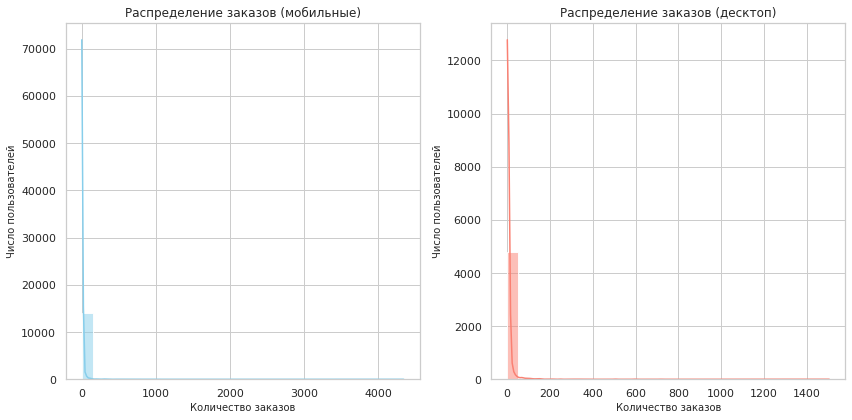

In [46]:
# Фильтрация данных за осень
autumn_df = total_df[total_df['season'] == 'осень']

# Группируем по user_id и device_type, считаем заказы
orders_per_user = (
    autumn_df.groupby(['user_id', 'device_type_canonical'])
    ['order_id'].count()
    .reset_index(name='orders')
)

# Разделяем на мобильных и десктопных пользователей
mobile_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'mobile']['orders']
desktop_orders = orders_per_user[orders_per_user['device_type_canonical'] == 'desktop']['orders']

# Настройка стиля графиков
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Гистограмма для мобильных пользователей
plt.subplot(1, 2, 1)
sns.histplot(mobile_orders, bins=30, color='skyblue', kde=True)
plt.title('Распределение заказов (мобильные)', fontsize=12)
plt.xlabel('Количество заказов', fontsize=10)
plt.ylabel('Число пользователей', fontsize=10)

# Гистограмма для десктопных пользователей
plt.subplot(1, 2, 2)
sns.histplot(desktop_orders, bins=30, color='salmon', kde=True)
plt.title('Распределение заказов (десктоп)', fontsize=12)
plt.xlabel('Количество заказов', fontsize=10)
plt.ylabel('Число пользователей', fontsize=10)

plt.tight_layout()
plt.show()

Выборки для проверки данной гипотезы будут состоять из количества заказов для уникальных `user_id`, т.е. мы имеем дискретные данные. Распределение заказов на пользователя, не нормальное (есть много пользователей с 1-2 заказами и мало с большим числом).Альтернативная гипотеза правосторонняя. Для проверки подойдет тест Манна — Уитни.

In [47]:
# Проведем тест Манна — Уитни
alpha = 0.05
mw_test = mannwhitneyu(
    mobile_orders, 
    desktop_orders, 
    alternative='greater' 
)
if mw_test.pvalue > alpha:
    print(f'pvalue={mw_test.pvalue} > {alpha}')
    print('Нулевая гипотеза находит подтверждение!')
else:
    print(f'pvalue={mw_test.pvalue} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения!')

pvalue=3.1996186837090383e-07 < 0.05
Нулевая гипотеза не находит подтверждения!


Проверим гипотизу:
- Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Сформулируем нулевую и альтернативную гипотез:
- Н0: Среднее время между заказами пользователей мобильных приложений и пользователями стационарных устройств равны;
- Н1: Среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Нам необходимо сравнить средние значения двух независимых групп, альтернативная гипотиза правосторонняя для проверки гипотез выберим ttest_ind.

In [48]:
# Выбор данных по устройствам + удаление NaN в days_since_prev
mobile_time = autumn_df[autumn_df['device_type_canonical'] == 'mobile']['days_since_prev'].dropna()
desktop_time = autumn_df[autumn_df['device_type_canonical'] == 'desktop']['days_since_prev'].dropna()

# Проводим t-тест
alpha = 0.05 

results = st.ttest_ind(
    mobile_time, 
    desktop_time,
    alternative='greater' 
)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')


p-значение: 6.545927426941386e-21
Отвергаем нулевую гипотезу


**Вывод:**
- **Не подтверждаем гипотезу:** среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств.
- **Подтверждаем гипотезу:** среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств.

Для полноты можно было бы ещё добавить формальный тест на нормальность (например, Шапиро), но и без него выводы выглядят уверенно.

<a id='intro-9'></a>
##  Общий вывод и рекомендации

Проведённый анализ данных онлайн-сервиса продажи позволил выявить ключевые тенденции в пользовательском поведении и динамике спроса на мероприятия осенью 2024 года. Основные выводы:

**Сезонные изменения спроса**

Осенью наблюдается рост заказов на мероприятия для детей (0+, 12+) и снижение спроса на события для взрослых (16+, 18+).

Культурные (театры, ёлки) и спортивные мероприятия дешевеют, тогда как развлекательные (стендапы, выставки) дорожают.

*Рекомендация: Увеличить продвижение семейных и детских мероприятий осенью, а также предлагать скидки на культурные события для стимулирования спроса.*

**Активность пользователей**

Пик активности приходится на начало месяца, а в будни пользователи совершают больше заказов, но по более низким ценам.

*Рекомендация: Запускать рекламные кампании в начале месяца и предлагать премиальные билеты на выходные.*

**География и партнёры**

Основной спрос сконцентрирован в двух регионах (Каменевский регион и Североярская область).

Наиболее активные партнёры – "Лови билет!", "Билеты без проблем", "Билеты в руки".

*Рекомендация: Усилить сотрудничество с топовыми партнёрами и изучить потенциал менее активных регионов.*

**Поведение пользователей с разных устройств**

Гипотеза о большем количестве заказов с мобильных устройств не подтвердилась.

Пользователи мобильного приложения делают заказы с большими перерывами, нежели со стационарных устройств.

*Рекомендация: Оптимизировать мобильное приложение для увеличения частоты заказов (например, push-уведомления о новых событиях).*

[Содержание проекта](#intro-10)